### Instalação de bibliotecas
FastF1 Getting Started: https://docs.fastf1.dev/examples/index.html

In [20]:
#!pip install fastf1
#!pip install colormap
#!pip install mplcyberpunk
#!pip install pandas

In [21]:
# Importando as bibliotecas necessárias
import seaborn as sns
import fastf1
import fastf1.plotting
import pandas as pd
import logging
import numpy as np
import matplotlib as mpl

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt


#### Tipos de Sessões e Exemplos

FP1: Primeiro treino livre.
FP2: Segundo treino livre.
FP3: Terceiro treino livre.

FP4: Quarto treino livre (se aplicável).
S: Corrida de sprint (se aplicável).

Q: Sessão de qualificação.
R: Corrida principal (grande prêmio).

In [22]:
# activate the fastf1 color scheme (and no other modifications)
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

c:\Users\lukas\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\plotting\_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(


In [23]:
year = 2024
wknd = 17
ses = 'Q'
driver = 'LEC'
colormap = mpl.cm.plasma

In [24]:
# Load race session data
race = fastf1.get_session(year, wknd, ses)
weekend = race.event
# Baixando os dados da sessão
race.load()
laps = race.laps.pick_quicklaps()

# Transform laps to get LapTime in seconds
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '10', '27', '18', '3', '4', '77', '24', '31']


In [25]:
race.results.iloc[0:10].loc[:, ['Abbreviation', 'Q3']]

,Abbreviation,Q3
16,LEC,0 days 00:01:41.365000
81,PIA,0 days 00:01:41.686000
55,SAI,0 days 00:01:41.805000
11,PER,0 days 00:01:41.813000
63,RUS,0 days 00:01:19.440000
1,VER,0 days 00:01:42.023000
44,HAM,0 days 00:01:42.289000
14,ALO,0 days 00:01:42.369000
43,COL,0 days 00:01:42.530000
23,ALB,0 days 00:01:42.859000


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


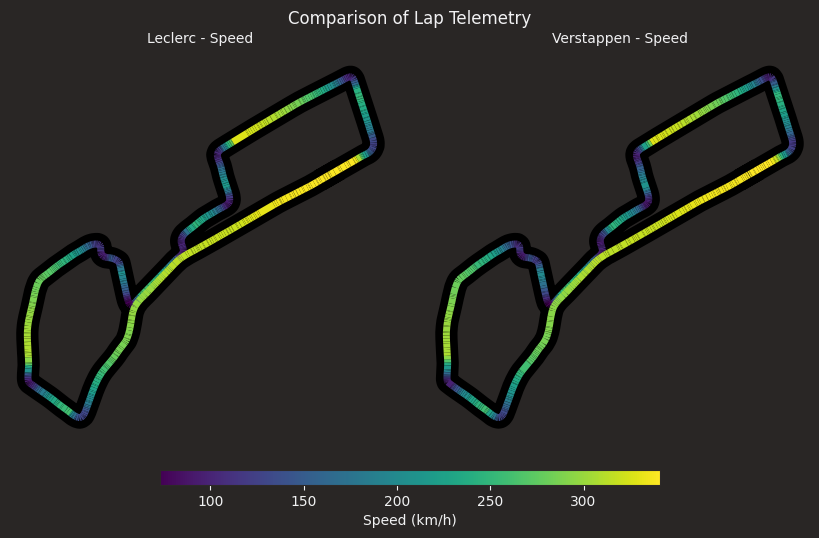

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import numpy as np

# Função para plotar telemetria de um piloto
def plot_telemetry(ax, lap, driver_name, colormap):
    # Dados de telemetria
    x = lap.telemetry['X']              # valores para o eixo X
    y = lap.telemetry['Y']              # valores para o eixo Y
    color = lap.telemetry['Speed']      # valor para o gradiente de cor

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plotar linha de fundo da pista
    ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

    # Criar gradiente de cor com base na velocidade
    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm,
                        linestyle='-', linewidth=5)

    # Set the values used for colormapping
    lc.set_array(color)

    # Adicionar ao gráfico
    ax.add_collection(lc)
    ax.set_title(f'{driver_name} - Speed', size=10)
    ax.axis('off')

# Criar figura com dois subplots lado a lado
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle('Comparison of Lap Telemetry', size=12, y=1)

# Ajustar margens e espaçamento entre os gráficos
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1)

# Plotar telemetria de Leclerc no primeiro gráfico
lap_leclerc = race.laps.pick_driver('LEC').pick_fastest()  # Defina corretamente o piloto
plot_telemetry(axs[0], lap_leclerc, 'Leclerc', 'viridis')

# Plotar telemetria de Verstappen no segundo gráfico
lap_verstappen = race.laps.pick_driver('VER').pick_fastest()  # Defina corretamente o piloto
plot_telemetry(axs[1], lap_verstappen, 'Verstappen', 'viridis')

# Adicionar barra de cores na parte inferior
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.03])
normlegend = mpl.colors.Normalize(vmin=min(lap_leclerc.telemetry['Speed'].min(), lap_verstappen.telemetry['Speed'].min()), 
                                  vmax=max(lap_leclerc.telemetry['Speed'].max(), lap_verstappen.telemetry['Speed'].max()))
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap='viridis', orientation="horizontal")
legend.set_label('Speed (km/h)', size=10)

plt.show()


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


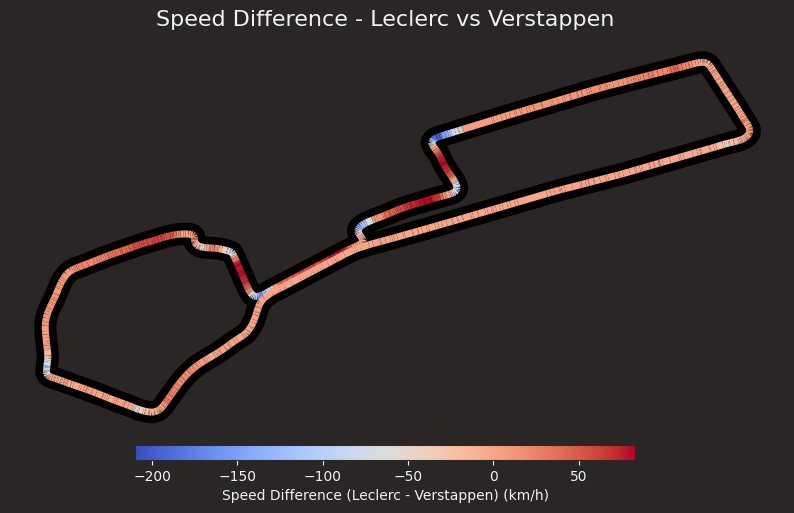

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import numpy as np

# Função para calcular e plotar a diferença de velocidade entre dois pilotos
def plot_speed_difference(ax, lap1, lap2, driver1_name, driver2_name, colormap):
    # Dados de telemetria de ambos os pilotos
    x = lap1.telemetry['X']  # valores para o eixo X (assumimos que ambos têm os mesmos valores X e Y)
    y = lap1.telemetry['Y']  # valores para o eixo Y
    speed_diff = lap1.telemetry['Speed'] - lap2.telemetry['Speed']  # diferença de velocidade

    # Converter para segmentos para a plotagem
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plotar a linha de fundo da pista
    ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

    # Criar gradiente de cor com base na diferença de velocidade
    norm = plt.Normalize(speed_diff.min(), speed_diff.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

    # Aplicar a coloração pela diferença de velocidade
    lc.set_array(speed_diff)

    # Adicionar ao gráfico
    ax.add_collection(lc)
    #ax.set_title(f'Difference in Speed: {driver1_name} vs {driver2_name}', size=10)
    ax.axis('off')

    # Adicionar números das curvas no gráfico
    #for corner in circuit.iterrows():
    #    corner_number = corner[1]['Number']
    #    corner_x = corner[1]['X']
    #    corner_y = corner[1]['Y']
    #    ax.text(corner_x, corner_y, str(corner_number), color='white', fontsize=12, ha='center', va='center')

# Criar figura para o heatmap
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Speed Difference - Leclerc vs Verstappen', size=16, y=0.95)

# Obter as voltas mais rápidas de Leclerc e Verstappen
lap_leclerc = race.laps.pick_driver('LEC').pick_fastest()  # Substitua pelos dados corretos
lap_verstappen = race.laps.pick_driver('VER').pick_fastest()  # Substitua pelos dados corretos

# Plotar a diferença de velocidade
plot_speed_difference(ax, lap_leclerc, lap_verstappen, 'Leclerc', 'Verstappen', 'coolwarm')

# Adicionar barra de cores para a diferença de velocidade
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Posição da barra de cores
normlegend = mpl.colors.Normalize(vmin=(lap_leclerc.telemetry['Speed'] - lap_verstappen.telemetry['Speed']).min(), 
                                  vmax=(lap_leclerc.telemetry['Speed'] - lap_verstappen.telemetry['Speed']).max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap='coolwarm', orientation="horizontal")
legend.set_label('Speed Difference (Leclerc - Verstappen) (km/h)', size=10)

plt.show()


In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import numpy as np
import fastf1

# Função para calcular e plotar a diferença de velocidade entre dois pilotos
def plot_speed_difference_with_corners(ax, lap1, lap2, driver1_name, driver2_name, colormap, circuit):
    # Dados de telemetria de ambos os pilotos
    x = lap1.telemetry['X']  # valores para o eixo X (assumimos que ambos têm os mesmos valores X e Y)
    y = lap1.telemetry['Y']  # valores para o eixo Y
    speed_diff = lap1.telemetry['Speed'] - lap2.telemetry['Speed']  # diferença de velocidade

    # Converter para segmentos para a plotagem
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plotar a linha de fundo da pista
    ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

    # Criar gradiente de cor com base na diferença de velocidade
    norm = plt.Normalize(speed_diff.min(), speed_diff.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

    # Aplicar a coloração pela diferença de velocidade
    lc.set_array(speed_diff)

    # Adicionar ao gráfico
    ax.add_collection(lc)
    ax.set_title(f'Difference in Speed: {driver1_name} vs {driver2_name}', size=10)
    ax.axis('off')

    # Adicionar números das curvas no gráfico
    for corner in circuit.iterrows():
        corner_number = corner[1]['Number']
        corner_x = corner[1]['X']
        corner_y = corner[1]['Y']
        ax.text(corner_x, corner_y, str(corner_number), color='white', fontsize=12, ha='center', va='center')

# Baixar dados do evento e do circuito
race = fastf1.get_event(2024, 'Azerbaijan Grand Prix')
track = race.get_track()  # Obtém os dados do circuito (apexes das curvas)

# Criar figura para o heatmap
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Speed Difference - Leclerc vs Verstappen', size=16, y=0.95)

# Obter as voltas mais rápidas de Leclerc e Verstappen
lap_leclerc = race.laps.pick_driver('LEC').pick_fastest()  # Substitua pelos dados corretos
lap_verstappen = race.laps.pick_driver('VER').pick_fastest()  # Substitua pelos dados corretos

# Plotar a diferença de velocidade com números das curvas
plot_speed_difference_with_corners(ax, lap_leclerc, lap_verstappen, 'Leclerc', 'Verstappen', 'coolwarm', track)

# Adicionar barra de cores para a diferença de velocidade
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Posição da barra de cores
normlegend = mpl.colors.Normalize(vmin=(lap_leclerc.telemetry['Speed'] - lap_verstappen.telemetry['Speed']).min(), 
                                  vmax=(lap_leclerc.telemetry['Speed'] - lap_verstappen.telemetry['Speed']).max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap='coolwarm', orientation="horizontal")
legend.set_label('Speed Difference (Leclerc - Verstappen) (km/h)', size=10)

plt.show()


AttributeError: 'Event' object has no attribute 'get_track'